### In this script, DBN has run and this script is used to make predictions
### In this script, DBN is run with 1s time bin, 3 time lag 
### In this script, the animal tracking is done with only one camera - camera 2 (middle) 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import scipy
import scipy.stats as st
import sklearn
from sklearn.neighbors import KernelDensity
import string
import warnings
import pickle

import os
import glob
import random
from time import time

from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
from pgmpy.base import DAG
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

### function - get body part location for each pair of cameras

In [2]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair
from ana_functions.body_part_locs_singlecam import body_part_locs_singlecam

### function - align the two cameras

In [3]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [4]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [5]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_singlecam import find_socialgaze_timepoint_singlecam
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody import find_socialgaze_timepoint_singlecam_wholebody

### function - define time point of behavioral events

In [6]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_singlecam import bhv_events_timepoint_singlecam

### function - plot behavioral events

In [7]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - make demo videos with skeleton and inportant vectors

In [8]:
from ana_functions.tracking_video_singlecam_demo import tracking_video_singlecam_demo
from ana_functions.tracking_video_singlecam_wholebody_demo import tracking_video_singlecam_wholebody_demo

### function - interval between all behavioral events

In [9]:
from ana_functions.bhv_events_interval import bhv_events_interval
from ana_functions.bhv_events_interval import bhv_events_interval_certainEdges

### function - train the dynamic bayesian network - multi time lag (3 lags)

In [10]:
from ana_functions.train_DBN_multiLag import train_DBN_multiLag
from ana_functions.train_DBN_multiLag import train_DBN_multiLag_create_df_only
from ana_functions.train_DBN_multiLag import train_DBN_multiLag_training_only
from ana_functions.train_DBN_multiLag import graph_to_matrix
from ana_functions.train_DBN_multiLag import get_weighted_dags
from ana_functions.train_DBN_multiLag import get_significant_edges
from ana_functions.train_DBN_multiLag import threshold_edges
from ana_functions.train_DBN_multiLag import Modulation_Index
from ana_functions.EfficientTimeShuffling import EfficientShuffle
from ana_functions.AicScore import AicScore

## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)

In [11]:
# instead of using gaze angle threshold, use the target rectagon to deside gaze info
# ...need to update
sqr_thres_tubelever = 75 # draw the square around tube and lever
sqr_thres_face = 1.15 # a ratio for defining face boundary
sqr_thres_body = 4 # how many times to enlongate the face box boundry to the body


# get the fps of the analyzed video
fps = 30

# frame number of the demo video
# nframes = 0.5*30 # second*30fps
nframes = 2*30 # second*30fps

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 0

# only analyze the best (five) sessions for each conditions
do_bestsession = 1
if do_bestsession:
    savefile_sufix = '_bestsessions'
else:
    savefile_sufix = ''
    
# all the videos (no misaligned ones)
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used

# dodson scorch
if 0:
    if not do_bestsession:
        dates_list = [
                      "20220909","20220912","20220915","20220920","20220922","20220923","20221010",
                      "20221011","20221013","20221014","20221015","20221017","20230215",     
                      "20221018","20221019","20221020","20221021","20221022","20221026","20221028","20221030",
                      "20221107","20221108","20221109","20221110","20221111","20221114","20221115","20221116",
                      "20221117","20221118","20221121","20221122","20221123","20221125","20221128","20221129",              
                      "20221205","20221206","20221209","20221212","20221214","20221216","20221219","20221220",
                      "20221221","20230208","20230209","20230213","20230214","20230111","20230112","20230201",

                     ]
        session_start_times = [ 
                                 6.50, 18.10, 0,      33.03, 549.0, 116.80, 6.50,
                                 2.80, 27.80, 272.50, 27.90, 27.00,  33.00,
                                28.70, 45.30, 21.10,  27.10, 51.90,  21.00, 30.80, 17.50,                      
                                15.70,  2.65, 27.30,   0.00,  0.00,  71.80,  0.00,  0.00, 
                                75.50, 20.20,  0.00,  24.20, 36.70,  26.40, 22.50, 28.50,                       
                                 0.00,  0.00, 21.70,  84.70, 17.00,  19.80, 23.50, 25.20,  
                                 0.00,  0.00,  0.00,   0.00,  0.00, 130.00, 14.20, 24.20, 
                              ] # in second
    elif do_bestsession:
        # pick only five sessions for each conditions
        dates_list = [
                      # "20220912",
                      "20220915","20220920","20221010","20230208",
                      "20221011","20221013","20221015","20221017",
                      "20221022","20221026","20221028","20221030","20230209",
                      "20221125","20221128","20221129","20230214","20230215",                  
                      "20221205","20221206","20221209","20221214","20230112",
                      "20230117","20230118","20230124",
                      # "20230126",
                     ]
        session_start_times = [ 
                                # 18.10, 
                                 0.00, 33.03,  6.50,  0.00, 
                                 2.80, 27.80, 27.90, 27.00,  
                                51.90, 21.00, 30.80, 17.50,  0.00,                    
                                26.40, 22.50, 28.50,  0.00, 33.00,                     
                                 0.00,  0.00, 21.70, 17.00, 14.20, 
                                 0.00,  0.00,  0.00, 
                                 # 0.00,  
                              ] # in second
    
    animal1_fixedorder = ['dodson']
    animal2_fixedorder = ['scorch']

    animal1_filename = "Dodson"
    animal2_filename = "Scorch"
    
# eddie sparkle
if 0:
    if not do_bestsession:
        dates_list = [
                      "20221122","20221125","20221128","20221129","20221130","20221202","20221206",
                      "20221207","20221208","20221209","20230126","20230127","20230130","20230201","20230203-1",
                      "20230206","20230207","20230208-1","20230209","20230222","20230223-1","20230227-1",
                      "20230228-1","20230302-1","20230307-2","20230313","20230315","20230316","20230317",
                      "20230321","20230322","20230324","20230327","20230328",
                      "20230330","20230331","20230403","20230404","20230405","20230406","20230407",
                      
                   ]
        session_start_times = [ 
                                 8.00,38.00,1.00,3.00,5.00,9.50,1.00,
                                 4.50,4.50,5.00,38.00,166.00,4.20,3.80,3.60,
                                 7.50,9.00,7.50,8.50,14.50,7.80,8.00,7.50,
                                 8.00,8.00,4.00,123.00,14.00,8.80,
                                 7.00,7.50,5.50,11.00,9.00,
                                 17.00,4.50,9.30,25.50,20.40,21.30,24.80,
                                 
                              ] # in second
    elif do_bestsession:   
        dates_list = [
                      "20221122",  "20221125",  
                      "20221202",  "20221206",  "20230126",  "20230130",  "20230201",
                      "20230207",  "20230208-1","20230209",  "20230222",  "20230223-1",
                      "20230227-1","20230228-1","20230302-1","20230307-2","20230313",
                      "20230321",  "20230322",  "20230324",  "20230327",  "20230328",
                      "20230331",  "20230403",  "20230404",  "20230405",  "20230406"
                   ]
        session_start_times = [ 
                                  8.00,  38.00, 
                                  9.50,   1.00, 38.00,  4.20,  3.80,
                                  9.00,   7.50,  8.50, 14.50,  7.80,
                                  8.00,   7.50,  8.00,  8.00,  4.00,
                                  7.00,   7.50,  5.50, 11.00,  9.00,
                                  4.50,   9.30, 25.50, 20.40, 21.30,
                              ] # in second
    
    animal1_fixedorder = ['eddie']
    animal2_fixedorder = ['sparkle']

    animal1_filename = "Eddie"
    animal2_filename = "Sparkle"
    
# ginger kanga
if 0:
    if not do_bestsession:
        dates_list = [
                      "20230209","20230213","20230214","20230216","20230222","20230223","20230228","20230302",
                      "20230303","20230307","20230314","20230315","20230316","20230317"         
                   ]
        session_start_times = [ 
                                 0.00,  0.00,  0.00, 48.00, 26.20, 18.00, 23.00, 28.50,
                                34.00, 25.50, 25.50, 31.50, 28.00, 30.50
                              ] # in second 
    elif do_bestsession:   
        dates_list = [
                      #"20230213",
                      "20230214","20230216",
                      "20230228","20230302","20230303","20230307",          
                      "20230314","20230315","20230316","20230317",
                      "20230301","20230320","20230321","20230322",
                      "20230323","20230412","20230413","20230517","20230614","20230615",
                      "20230522_ws","20230524","20230605_1","20230606","20230607"
                   ]
        session_start_times = [ 
                                # 0.00, 
                                 0.00, 48.00, 
                                23.00, 28.50, 34.00, 25.50, 
                                25.50, 31.50, 28.00, 30.50,
                                33.50, 22.20, 50.00,  0.00, 
                                33.00, 18.20, 22.80, 31.00, 24.00, 21.00,
                                 0.00,  0.00,  0.00,  0.00,  0.00,
                              ] # in second 
    
    animal1_fixedorder = ['ginger']
    animal2_fixedorder = ['kanga']

    animal1_filename = "Ginger"
    animal2_filename = "Kanga"

    
# dannon kanga
if 1:
    if not do_bestsession:
        dates_list = [
                      "20230718","20230720","20230914","20230829","20230907","20230915",
                      "20230918","20230926","20230928","20231002","20231010","20231011",
                      "20231013",
                   ]
        session_start_times = [ 
                                 0, 0, 0, 0, 0, 0, 
                                 0, 0, 0, 0, 0, 0,
                                 0, 0, 0, 0, 
                              ] # in second 
    elif do_bestsession:   
        dates_list = [
                      "20230718","20230720","20230914","20230726","20230727","20230809",
                      "20230810","20230811","20230814","20230816","20230829","20230907","20230915",
                      "20230918","20230926","20230928","20231002","20231010","20231011",
                      "20231013","20231020","20231024","20231025",
                   ]
        session_start_times = [ 
                                    0,    0,    0, 32.2, 27.2, 37.5,
                                 21.0, 21.5, 19.8, 32.0,    0,    0,   0, 
                                    0,    0,    0,    0,    0,    0,
                                    0,    0,    0,    0, 
                              ] # in second 
    
    animal1_fixedorder = ['dannon']
    animal2_fixedorder = ['kanga']

    animal1_filename = "Dannon"
    animal2_filename = "Kanga"
    
    
# Koala Vermelho
if 0:
    if not do_bestsession:
        dates_list = [
                      "20231221",  "20231222","20231226","20231227",  "20231229","20231230",
                      "20231231",  "20240102","20240104","20240104-2","20240105","20240108",
                      "20240109",  "20240115","20240116","20240117",  "20240118","20240119",
                      "20240122",  "20240123","20240124","20240125",  "20240126","20240129",
                      "20240130",  "20240131","20240201","20240202",  "20240205","20240206_1",
                      "20240206_2","20240207","20240208","20240209",  "20240212","20240213",
                      "20240214",  "20240215","20240216","20240219",  "20240220","20240222", 
                      "20240223",  "20240226",
                     ]
        session_start_times = [ 
                                0.00,  0.00,  0.00,  0.00,  0.00,  0.00, 
                                0.00,  0.00,  0.00,  0.00,  0.00,  0.00, 
                                0.00,  0.00,  0.00,  0.00,  0.00,  0.00,
                                0.00,  0.00,  0.00,  0.00,  0.00,  0.00,
                                0.00,  0.00,  0.00,  0.00,  0.00,  0.00,
                                0.00,  0.00,  0.00,  0.00,  0.00,  0.00,
                                0.00,  0.00,  0.00,  0.00,  0.00,  0.00,
                                0.00,  0.00,  
                              ] # in second
    elif do_bestsession:
        # pick only five sessions for each conditions
        dates_list = [
                      "20231222","20231226","20231227",  "20231229","20231230",
                      "20231231","20240102","20240104-2","20240105","20240108",
                      "20240109","20240115","20240116",  "20240117","20240118","20240119",
                      "20240207","20240208","20240209",  "20240212","20240213",
                      "20240214","20240215","20240216",  "20240220","20240222","20240223",
                     ]
        session_start_times = [ 
                                21.5,  0.00,  0.00,  0.00,  0.00, 
                                0.00,  12.2,  0.00,  18.8,  31.2,  
                                32.5,  0.00,  50.0,  0.00,  37.5,  29.5,
                                58.5,  72.0,  0.00,  71.5,  70.5,
                                86.8,  94.0,  65.0,  68.8,  43.8,  13.2,
                              ] # in second
    
    animal1_fixedorder = ['koala']
    animal2_fixedorder = ['vermelho']

    animal1_filename = "Koala"
    animal2_filename = "Vermelho"
    
    
#    
# dates_list = ["20230718"]
# session_start_times = [0.00] # in second

ndates = np.shape(dates_list)[0]

session_start_frames = session_start_times * fps # fps is 30Hz

totalsess_time = 600

# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']


# which camera to analyzed
cameraID = 'camera-2'
cameraID_short = 'cam2'


# location of levers and tubes for camera 2
# get this information using DLC animal tracking GUI, the results are stored: 
# /home/ws523/marmoset_tracking_DLCv2/marmoset_tracking_with_lever_tube-weikang-2023-04-13/labeled-data/
considerlevertube = 1
considertubeonly = 0
# # camera 1
# lever_locs_camI = {'dodson':np.array([645,600]),'scorch':np.array([425,435])}
# tube_locs_camI  = {'dodson':np.array([1350,630]),'scorch':np.array([555,345])}
# # camera 2
lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
tube_locs_camI  = {'dodson':np.array([1550,515]),'scorch':np.array([350,515])}
# # lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
# # tube_locs_camI  = {'dodson':np.array([1650,490]),'scorch':np.array([250,490])}
# # camera 3
# lever_locs_camI = {'dodson':np.array([1580,440]),'scorch':np.array([1296,540])}
# tube_locs_camI  = {'dodson':np.array([1470,375]),'scorch':np.array([805,475])}


if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()

    
# define bhv events summarizing variables     
tasktypes_all_dates = np.zeros((ndates,1))
coopthres_all_dates = np.zeros((ndates,1))

succ_rate_all_dates = np.zeros((ndates,1))
interpullintv_all_dates = np.zeros((ndates,1))
trialnum_all_dates = np.zeros((ndates,1))

owgaze1_num_all_dates = np.zeros((ndates,1))
owgaze2_num_all_dates = np.zeros((ndates,1))
mtgaze1_num_all_dates = np.zeros((ndates,1))
mtgaze2_num_all_dates = np.zeros((ndates,1))
pull1_num_all_dates = np.zeros((ndates,1))
pull2_num_all_dates = np.zeros((ndates,1))

bhv_intv_all_dates = dict.fromkeys(dates_list, [])
pull_edges_intv_all_dates = dict.fromkeys(dates_list, [])


# where to save the summarizing data
data_saved_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/3d_recontruction_analysis_self_and_coop_task_data_saved/'


    

### load the DBN related data for each dyad and run the prediction

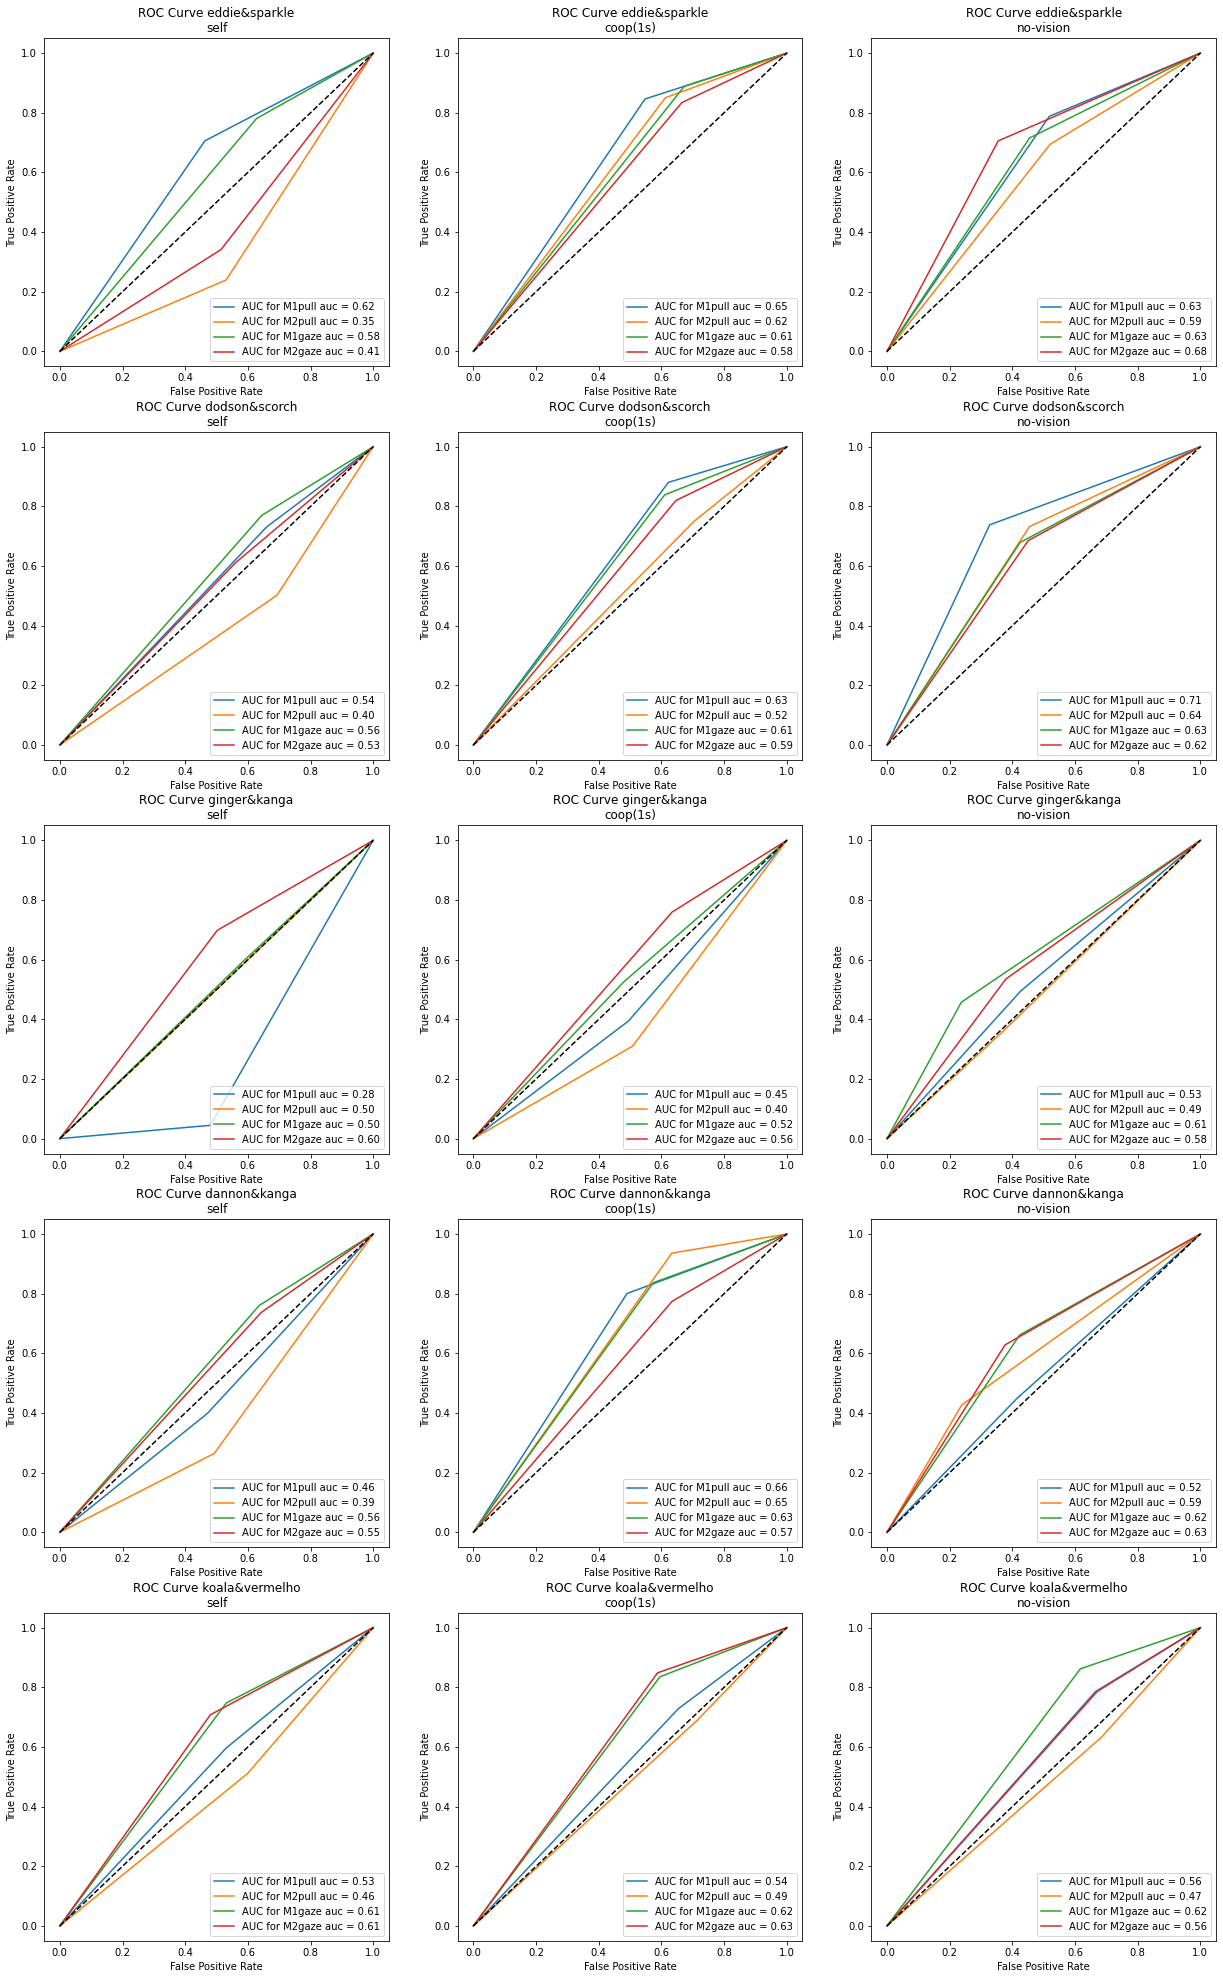

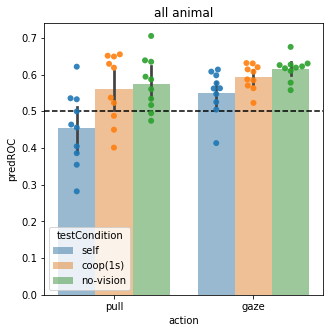

In [65]:
# PLOT multiple pairs in one plot, so need to load data seperately
moreSampSize = 0
mergetempRos = 0 # 1: merge different time bins

#
animal1_fixedorders = ['eddie','dodson','ginger','dannon','koala']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga','vermelho']
# animal1_fixedorders = ['eddie',]
# animal2_fixedorders = ['sparkle',]
nanimalpairs = np.shape(animal1_fixedorders)[0]

temp_resolu = 1

# ONLY FOR PLOT!! 
# define DBN related summarizing variables
DBN_group_typenames = ['self','coop(1s)','no-vision']
DBN_group_typeIDs  =  [1,3,5]
DBN_group_coopthres = [0,1,0]
# DBN_group_typenames = ['coop(1s)']
# DBN_group_typeIDs  =  [3]
# DBN_group_coopthres = [1]
nDBN_groups = np.shape(DBN_group_typenames)[0]

# DBN model
toNodes = ['pull1_t3','pull2_t3','owgaze1_t3','owgaze2_t3']
fromNodes = [ 'pull1_t0','pull2_t0','owgaze1_t0','owgaze2_t0',
              'pull1_t1','pull2_t1','owgaze1_t1','owgaze2_t1',
              'pull1_t2','pull2_t2','owgaze1_t2','owgaze2_t2']
# fromNodes = ['pull1_t2','pull2_t2','owgaze1_t2','owgaze2_t2']
eventnames = ["M1pull","M2pull","M1gaze","M2gaze"]
nevents = np.shape(eventnames)[0]

timelagtype = 'allthreelags'
time_lags = ['t_-3','t_-2','t_-1']
fromRowIDs =[0,1,2,3, 4,5,6,7, 8,9,10,11]
# time_lags = ['t_-2','t_-1']
# fromRowIDs =[4,5,6,7, 8,9,10,11]
# time_lags = ['t_-1']
# fromRowIDs =[8,9,10,11]

# initialize a summary dataframe for plotting the summary figure across animals 
ROC_summary_all = pd.DataFrame(columns=['animal','action','testCondition','predROC'])

fig, axs = plt.subplots(nanimalpairs,nDBN_groups) # nDBN_groups(3) task conditions; 2 animal individual
fig.set_figheight(7*nanimalpairs)
fig.set_figwidth(7*nDBN_groups)

for ianimalpair in np.arange(0,nanimalpairs,1):
    
    # initiate figure
    # fig, axs = plt.subplots(nDBN_groups,2) # nDBN_groups(3) task conditions; 2 animal individual
    # fig.set_figheight(8*nDBN_groups)
    # fig.set_figwidth(15*2)
    
    # load the DBN input data
    animal1_fixedorder = animal1_fixedorders[ianimalpair]
    animal2_fixedorder = animal2_fixedorders[ianimalpair]
    #
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    if not mergetempRos:
        with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            DBN_input_data_alltypes = pickle.load(f)
    else:
        with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_mergeTempsReSo.pkl', 'rb') as f:
            DBN_input_data_alltypes = pickle.load(f)
    
    # load the DBN training outcome
    if moreSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    else:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    # make sure these variables are the same as in the previous steps
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]
    #
    if moreSampSize:
        # different data (down/re)sampling numbers
        # samplingsizes = np.arange(1100,3000,100)
        samplingsizes = [1100]
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
    else:
        samplingsizes_name = ['min_row_number']   
    nsamplings = np.shape(samplingsizes_name)[0]

    #
    temp_resolu = temp_resolus[0]
    j_sampsize_name = samplingsizes_name[0]    

    
            
    for igroup in np.arange(0,nDBN_groups,1):
        DBN_group_typename = DBN_group_typenames[igroup]
        
        DBN_input_data_tgt = DBN_input_data_alltypes[DBN_group_typename]
        weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][DBN_group_typename]
        weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][DBN_group_typename]
        # sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][DBN_group_typename]
        sig_edges_tgt = get_significant_edges(weighted_graphs_tgt,weighted_graphs_shuffled_tgt)
    
        # mean weight 
        weighted_graphs_mean_tgt = np.nanmean(weighted_graphs_tgt,axis=0)
        weighted_graphs_mean_tgt = weighted_graphs_mean_tgt * sig_edges_tgt
        
        bina_graphs_mean_tgt = sig_edges_tgt
        
        # Split data into training and testing sets
        train_data, test_data = train_test_split(DBN_input_data_tgt, test_size=0.2)
        test_data = DBN_input_data_tgt
        
        # get the true bhv data from the test_data set
        trueBhv = test_data[toNodes]
        
        # test on the test_data
        fromNodeBhv = test_data[fromNodes]
        
        # only use binary weight (not considering the weights)
        predBhv = 1*(np.dot(np.array(fromNodeBhv),bina_graphs_mean_tgt[fromRowIDs,:])>0)
        
        for ievent in np.arange(0,nevents,1):
            auc = roc_auc_score(np.array(trueBhv)[:,ievent], predBhv[:,ievent])
            
            fpr, tpr, _ = roc_curve(np.array(trueBhv)[:,ievent], predBhv[:,ievent])

            axs[ianimalpair,igroup].plot(fpr, tpr, 
                                         label=f'AUC for '+eventnames[ievent]+' auc = '+"{:.2f}".format(auc))
            
            # put data in the summarizing data frame
            if ievent<2: # for animal1
                ROC_summary_all = ROC_summary_all.append({'animal':animal1_fixedorder,
                                                          'action':eventnames[ievent][2:],
                                                          'testCondition':DBN_group_typename,
                                                          'predROC':auc
                                                         }, ignore_index=True)
            else:
                ROC_summary_all = ROC_summary_all.append({'animal':animal2_fixedorder,
                                                          'action':eventnames[ievent][2:],
                                                          'testCondition':DBN_group_typename,
                                                          'predROC':auc
                                                         }, ignore_index=True)
                
        axs[ianimalpair,igroup].plot([0, 1], [0, 1], 'k--')
        axs[ianimalpair,igroup].set_xlabel('False Positive Rate')
        axs[ianimalpair,igroup].set_ylabel('True Positive Rate')
        axs[ianimalpair,igroup].set_title('ROC Curve '+animal1_fixedorder+'&'+animal2_fixedorder+'\n'+DBN_group_typename)
        axs[ianimalpair,igroup].legend(loc='lower right')
        
        
savefig = 1
if savefig:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions/'+savefile_sufix+'/'+cameraID+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    fig.savefig(figsavefolder+'withinCondition_DBNpredicition_fullDBN_binaryGraph_'+timelagtype+'.pdf')
    
    
# plot the summarizing figure
fig2, axs2 = plt.subplots(1,1)
fig2.set_figheight(5)
fig2.set_figwidth(5)
seaborn.barplot(ax=axs2,data=ROC_summary_all,x='action',y='predROC',hue='testCondition',errorbar='ci',alpha=.5)
seaborn.swarmplot(ax=axs2,data=ROC_summary_all,x='action',y='predROC',hue='testCondition',alpha=.9,size=6,dodge=True,legend=False)
plt.plot([-0.5,1.5],[0.5,0.5],'k--')
axs2.set_xlim([-0.5,1.5])
axs2.set_title('all animal')

savefig = 1
if savefig:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions/'+savefile_sufix+'/'+cameraID+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    fig2.savefig(figsavefolder+'withinCondition_DBNpredicition_fullDBN_binaryGraph_'+timelagtype+'_summarizingplot.pdf')
    




### load the DBN related data for each dyad and run the prediction
### from one task condition to test on another task condition

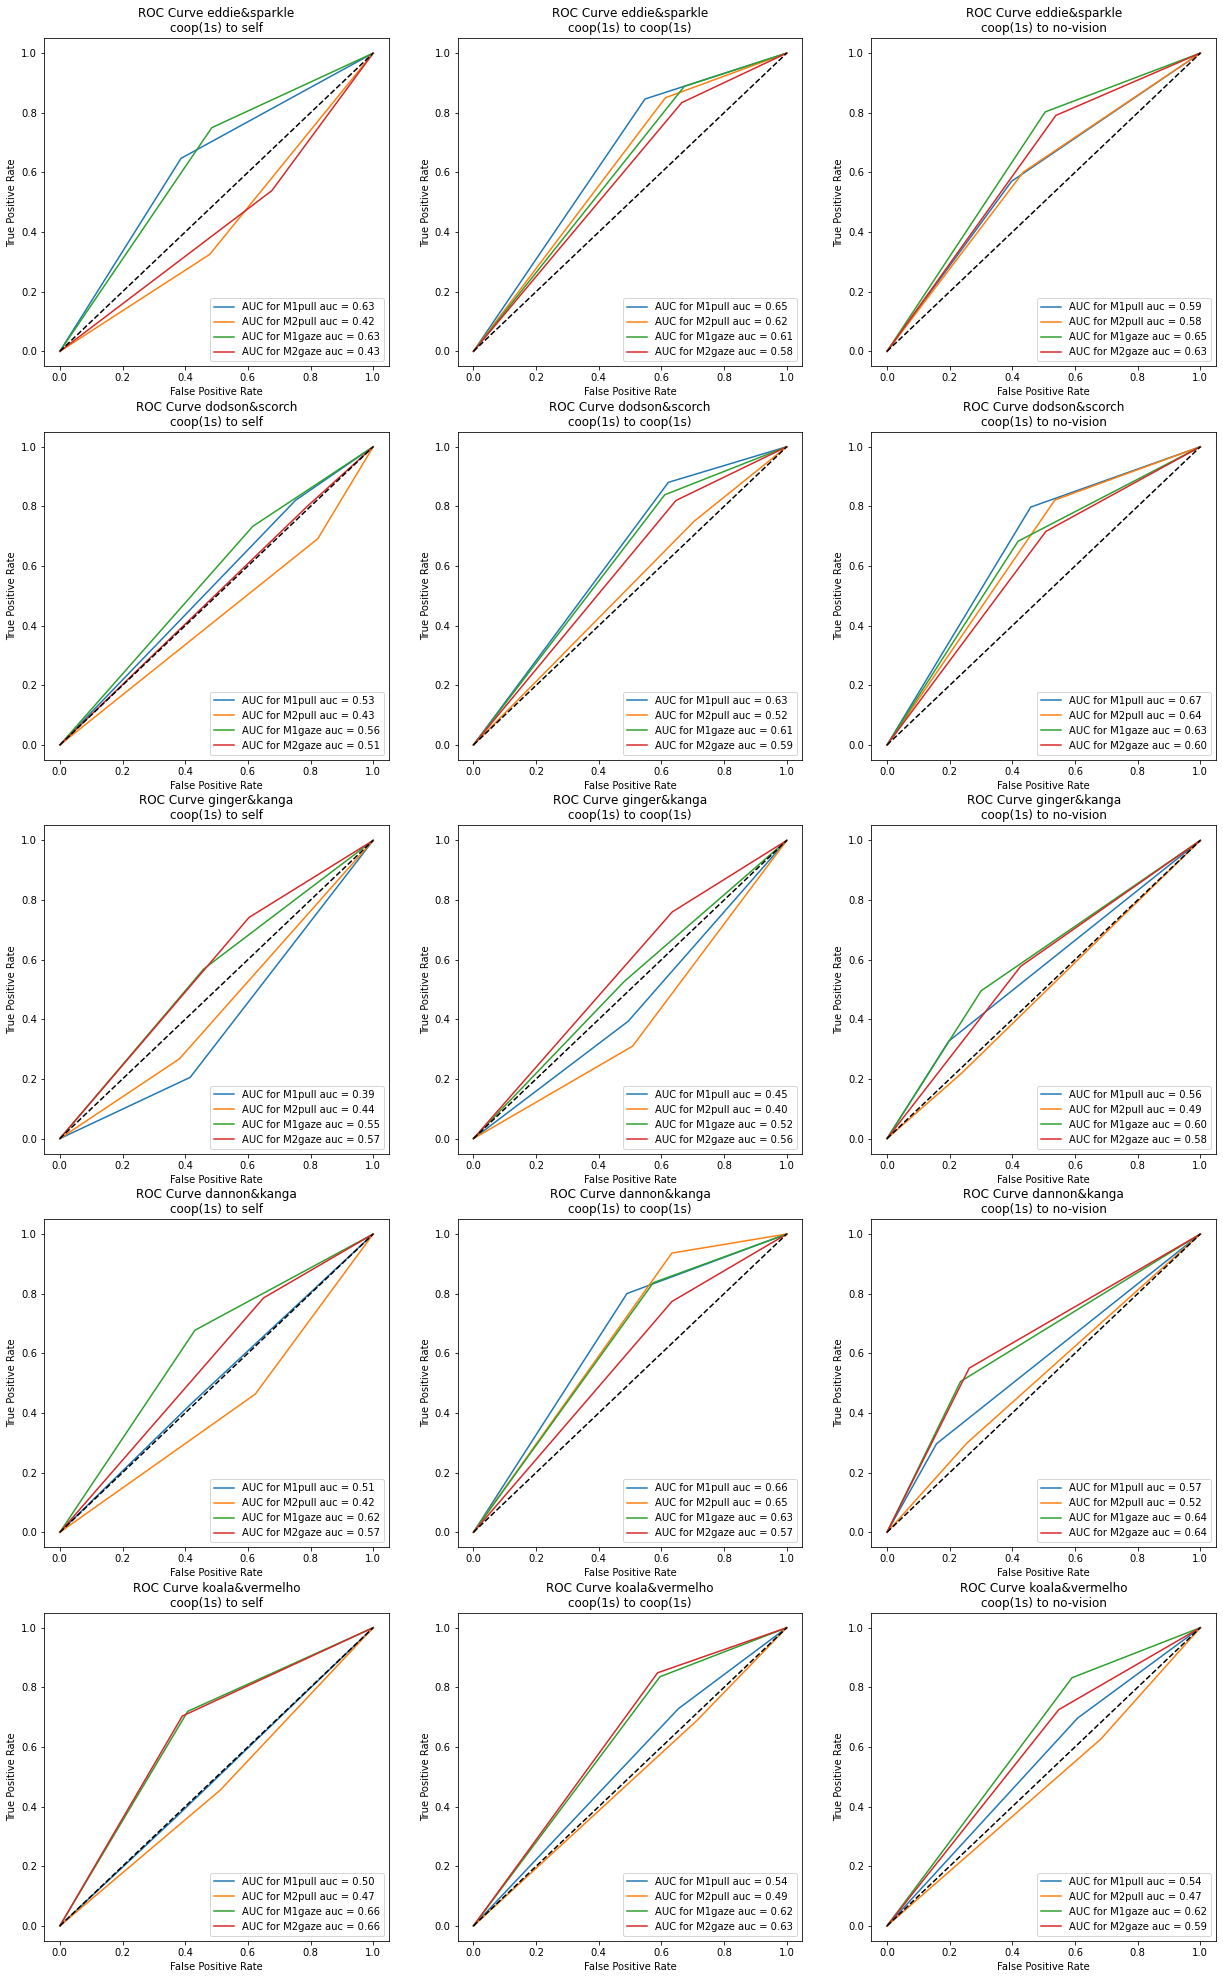

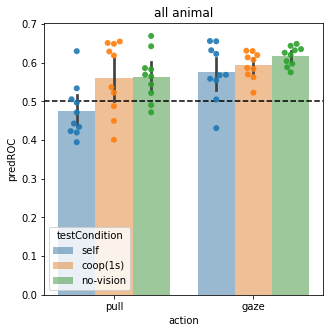

In [63]:
# PLOT multiple pairs in one plot, so need to load data seperately
moreSampSize = 0
mergetempRos = 0 # 1: merge different time bins

#
animal1_fixedorders = ['eddie','dodson','ginger','dannon','koala']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga','vermelho']
# animal1_fixedorders = ['eddie',]
# animal2_fixedorders = ['sparkle',]
nanimalpairs = np.shape(animal1_fixedorders)[0]

temp_resolu = 1

# define DBN related summarizing variables
DBN_group_typenames_train = ['coop(1s)','coop(1s)','coop(1s)']
DBN_group_typeIDs_train  =  [3,3,3]
DBN_group_coopthres_train = [1,1,1]
#
DBN_group_typenames_test = ['self','coop(1s)','no-vision']
DBN_group_typeIDs_test  =  [1,3,5]
DBN_group_coopthres_test = [0,1,0]
#
nDBN_groups = np.shape(DBN_group_typenames_train)[0]

# DBN model
toNodes = ['pull1_t3','pull2_t3','owgaze1_t3','owgaze2_t3']
fromNodes = [ 'pull1_t0','pull2_t0','owgaze1_t0','owgaze2_t0',
              'pull1_t1','pull2_t1','owgaze1_t1','owgaze2_t1',
              'pull1_t2','pull2_t2','owgaze1_t2','owgaze2_t2']
# fromNodes = ['pull1_t2','pull2_t2','owgaze1_t2','owgaze2_t2']
eventnames = ["M1pull","M2pull","M1gaze","M2gaze"]
nevents = np.shape(eventnames)[0]

timelagtype = 'allthreelags'
time_lags = ['t_-3','t_-2','t_-1']
fromRowIDs =[0,1,2,3, 4,5,6,7, 8,9,10,11]
# time_lags = ['t_-2','t_-1']
# fromRowIDs =[4,5,6,7, 8,9,10,11]
# time_lags = ['t_-1']
# fromRowIDs =[8,9,10,11]

# initialize a summary dataframe for plotting the summary figure across animals 
ROC_summary_all = pd.DataFrame(columns=['animal','action','testCondition','predROC'])

fig, axs = plt.subplots(nanimalpairs,nDBN_groups) # nDBN_groups(3) task conditions; 2 animal individual
fig.set_figheight(7*nanimalpairs)
fig.set_figwidth(7*nDBN_groups)

for ianimalpair in np.arange(0,nanimalpairs,1):
    
    # initiate figure
    # fig, axs = plt.subplots(nDBN_groups,2) # nDBN_groups(3) task conditions; 2 animal individual
    # fig.set_figheight(8*nDBN_groups)
    # fig.set_figwidth(15*2)
    
    # load the DBN input data
    animal1_fixedorder = animal1_fixedorders[ianimalpair]
    animal2_fixedorder = animal2_fixedorders[ianimalpair]
    #
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
    if not mergetempRos:
        with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
            DBN_input_data_alltypes = pickle.load(f)
    else:
        with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_mergeTempsReSo.pkl', 'rb') as f:
            DBN_input_data_alltypes = pickle.load(f)
    
    # load the DBN training outcome
    if moreSampSize:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)
    else:
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    # make sure these variables are the same as in the previous steps
    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]
    #
    if moreSampSize:
        # different data (down/re)sampling numbers
        # samplingsizes = np.arange(1100,3000,100)
        samplingsizes = [1100]
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
    else:
        samplingsizes_name = ['min_row_number']   
    nsamplings = np.shape(samplingsizes_name)[0]

    #
    temp_resolu = temp_resolus[0]
    j_sampsize_name = samplingsizes_name[0]    

    
            
    for igroup in np.arange(0,nDBN_groups,1):
        
        DBN_group_typename_train = DBN_group_typenames_train[igroup]
        DBN_group_typename_test  = DBN_group_typenames_test[igroup]
        
        #
        # training dataset
        DBN_input_data_tgt_train = DBN_input_data_alltypes[DBN_group_typename_train]
        weighted_graphs_tgt_train = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][DBN_group_typename_train]
        weighted_graphs_shuffled_tgt_train = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][DBN_group_typename_train]
        # sig_edges_tgt_train = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][DBN_group_typename_train]
        sig_edges_tgt_train = get_significant_edges(weighted_graphs_tgt_train,weighted_graphs_shuffled_tgt_train)
    
        # mean weight 
        weighted_graphs_mean_tgt_train = np.nanmean(weighted_graphs_tgt_train,axis=0)
        weighted_graphs_mean_tgt_train = weighted_graphs_mean_tgt_train * sig_edges_tgt_train
        
        bina_graphs_mean_tgt_train = sig_edges_tgt_train
        
        train_data = DBN_input_data_tgt_train
        
        #
        # testing dataset
        DBN_input_data_tgt_test = DBN_input_data_alltypes[DBN_group_typename_test]
        weighted_graphs_tgt_test = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][DBN_group_typename_test]
        weighted_graphs_shuffled_tgt_test = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][DBN_group_typename_test]
        # sig_edges_tgt_test = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][DBN_group_typename_test]
        sig_edges_tgt_test = get_significant_edges(weighted_graphs_tgt_test,weighted_graphs_shuffled_tgt_test)
    
        # mean weight 
        weighted_graphs_mean_tgt_test = np.nanmean(weighted_graphs_tgt_test,axis=0)
        weighted_graphs_mean_tgt_test = weighted_graphs_mean_tgt_test * sig_edges_tgt_test
        
        bina_graphs_mean_tgt_test = sig_edges_tgt_test
        
        test_data = DBN_input_data_tgt_test
        
        
        # get the true bhv data from the test_data set
        trueBhv = test_data[toNodes]
        
        # test on the test_data
        fromNodeBhv = test_data[fromNodes]
        
        # only use binary weight (not considering the weights)
        predBhv = 1*(np.dot(np.array(fromNodeBhv),bina_graphs_mean_tgt_train[fromRowIDs,:])>0)
        
        for ievent in np.arange(0,nevents,1):
            auc = roc_auc_score(np.array(trueBhv)[:,ievent], predBhv[:,ievent])
            
            fpr, tpr, _ = roc_curve(np.array(trueBhv)[:,ievent], predBhv[:,ievent])

            axs[ianimalpair,igroup].plot(fpr, tpr, 
                                         label=f'AUC for '+eventnames[ievent]+' auc = '+"{:.2f}".format(auc))
       
    
            # put data in the summarizing data frame
            if ievent<2: # for animal1
                ROC_summary_all = ROC_summary_all.append({'animal':animal1_fixedorder,
                                                          'action':eventnames[ievent][2:],
                                                          'testCondition':DBN_group_typename_test,
                                                          'predROC':auc
                                                         }, ignore_index=True)
            else:
                ROC_summary_all = ROC_summary_all.append({'animal':animal2_fixedorder,
                                                          'action':eventnames[ievent][2:],
                                                          'testCondition':DBN_group_typename_test,
                                                          'predROC':auc
                                                         }, ignore_index=True)
    
        axs[ianimalpair,igroup].plot([0, 1], [0, 1], 'k--')
        axs[ianimalpair,igroup].set_xlabel('False Positive Rate')
        axs[ianimalpair,igroup].set_ylabel('True Positive Rate')
        axs[ianimalpair,igroup].set_title('ROC Curve '+animal1_fixedorder+'&'+animal2_fixedorder+'\n'+DBN_group_typename_train+' to '+DBN_group_typename_test)
        axs[ianimalpair,igroup].legend(loc='lower right')
            
        
savefig = 1
if savefig:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions/'+savefile_sufix+'/'+cameraID+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    fig.savefig(figsavefolder+'acrossCondition_DBNpredicition_fullDBN_binaryGraph_'+timelagtype+'_DBNtrainedon'+DBN_group_typename_train+'.pdf')
    
    
# plot the summarizing figure
fig2, axs2 = plt.subplots(1,1)
fig2.set_figheight(5)
fig2.set_figwidth(5)
seaborn.barplot(ax=axs2,data=ROC_summary_all,x='action',y='predROC',hue='testCondition',errorbar='ci',alpha=.5)
seaborn.swarmplot(ax=axs2,data=ROC_summary_all,x='action',y='predROC',hue='testCondition',alpha=.9,size=6,dodge=True,legend=False)
plt.plot([-0.5,1.5],[0.5,0.5],'k--')
axs2.set_xlim([-0.5,1.5])
axs2.set_title('all animal')

savefig = 1
if savefig:
    figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions/'+savefile_sufix+'/'+cameraID+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    fig2.savefig(figsavefolder+'acrossCondition_DBNpredicition_fullDBN_binaryGraph_'+timelagtype+'_DBNtrainedon'+DBN_group_typename_train+'_summarizingplot.pdf')
    


4

### load the DBN related data for each dyad and run the prediction
### For each condition, only use the dependencies involved by each strategy

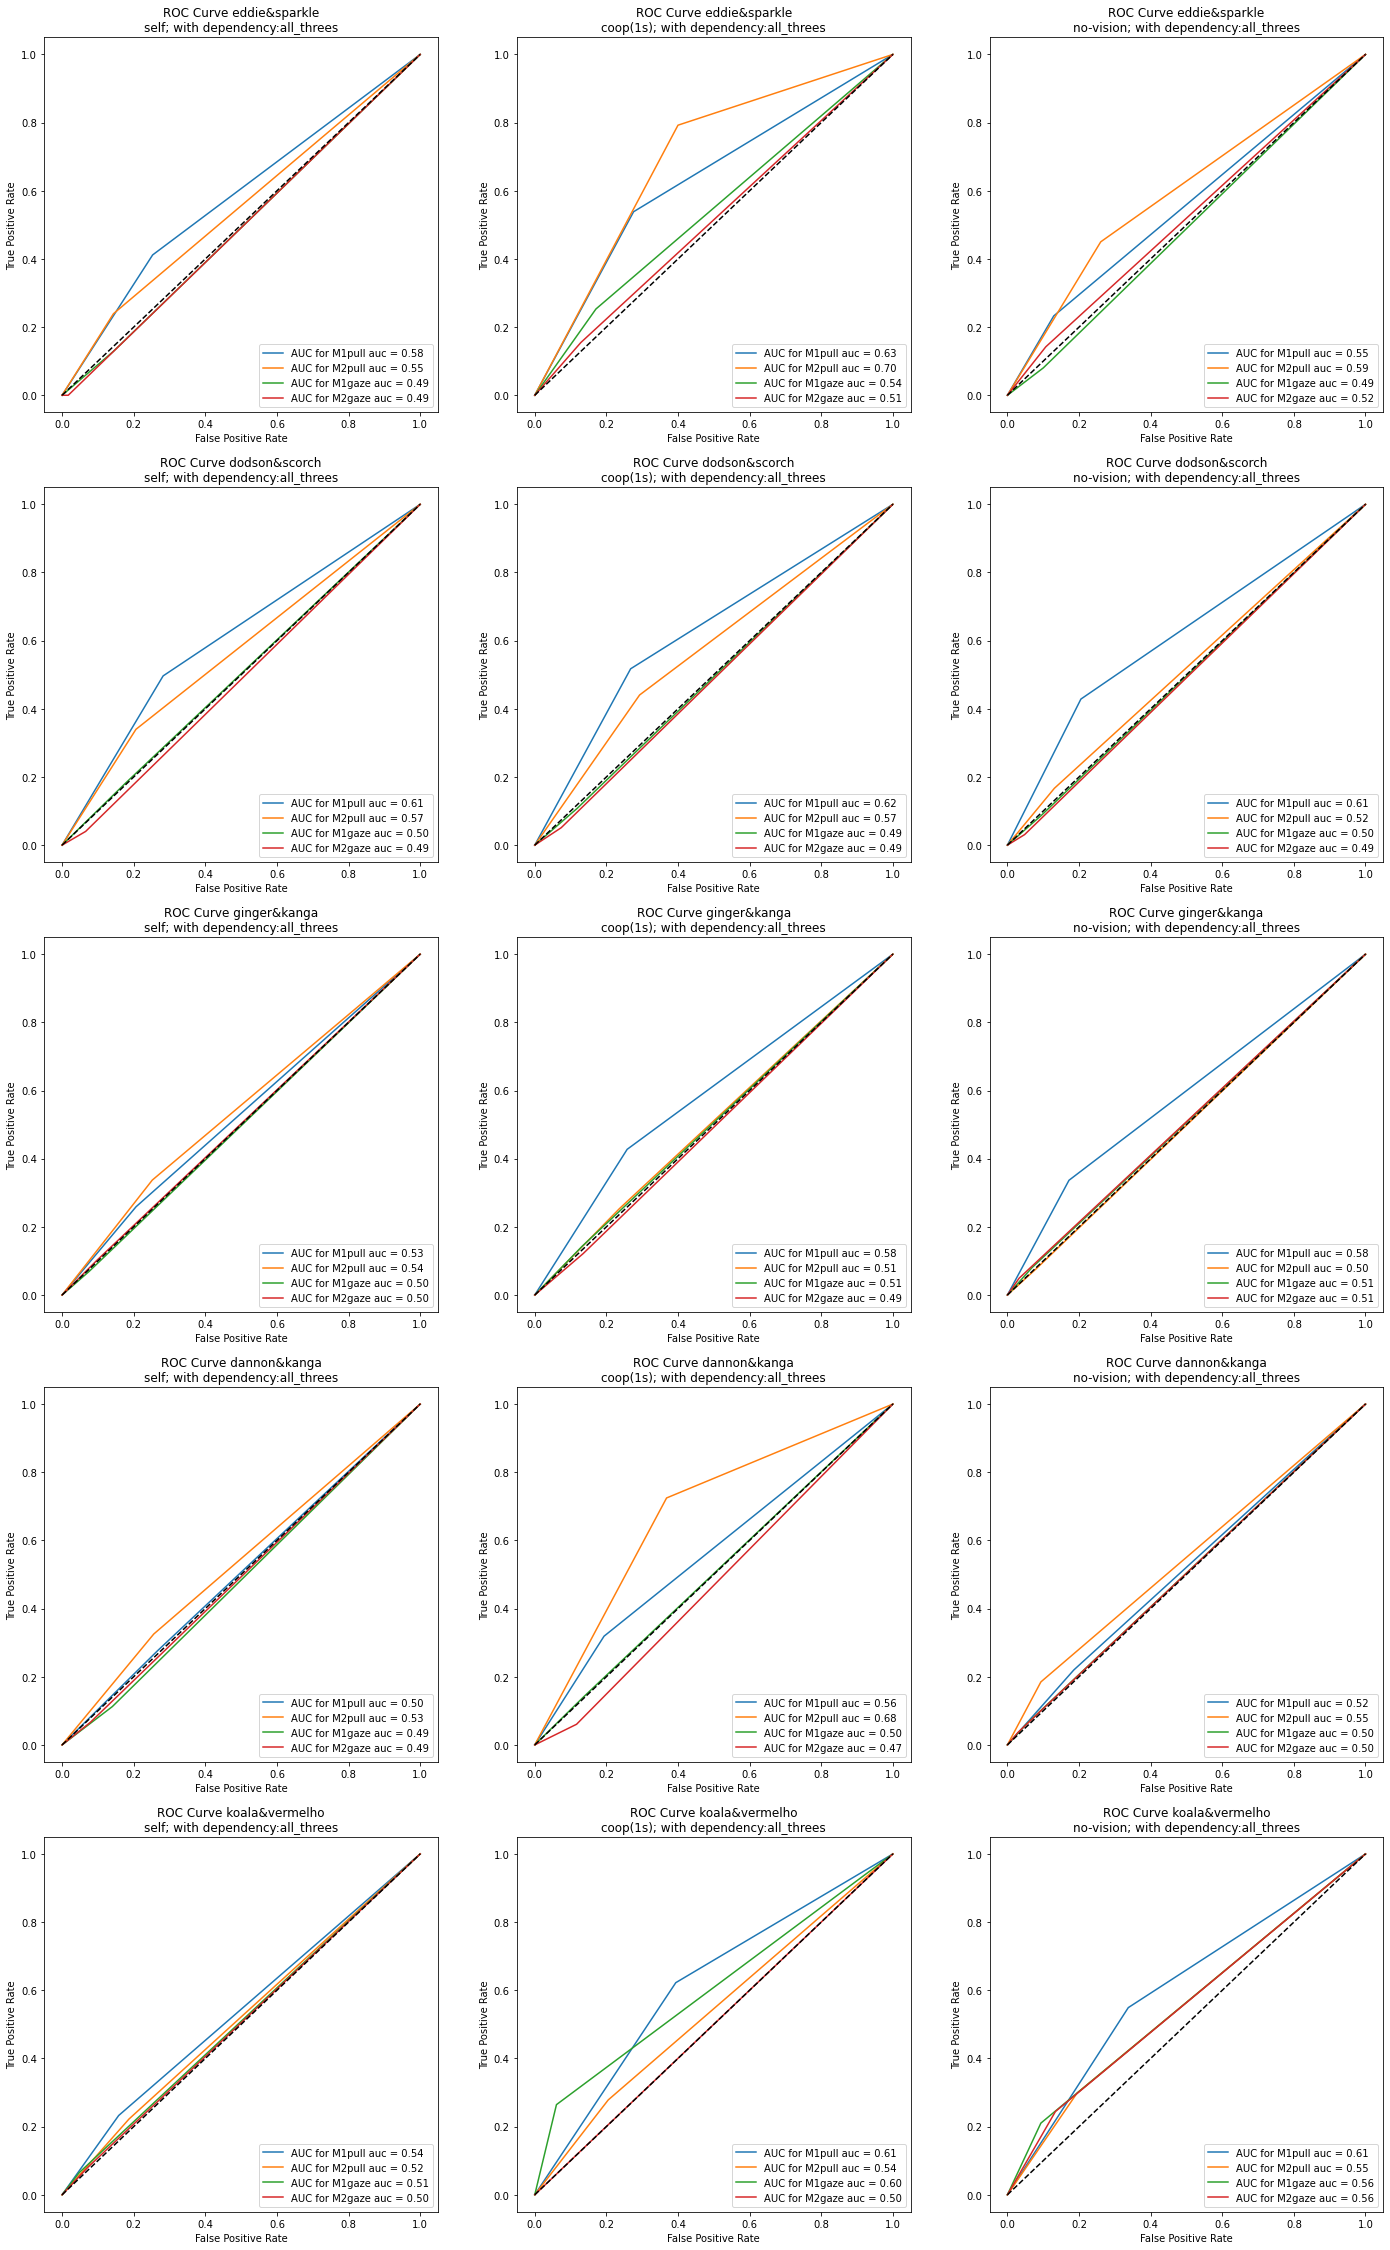

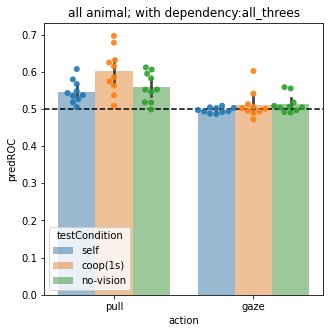

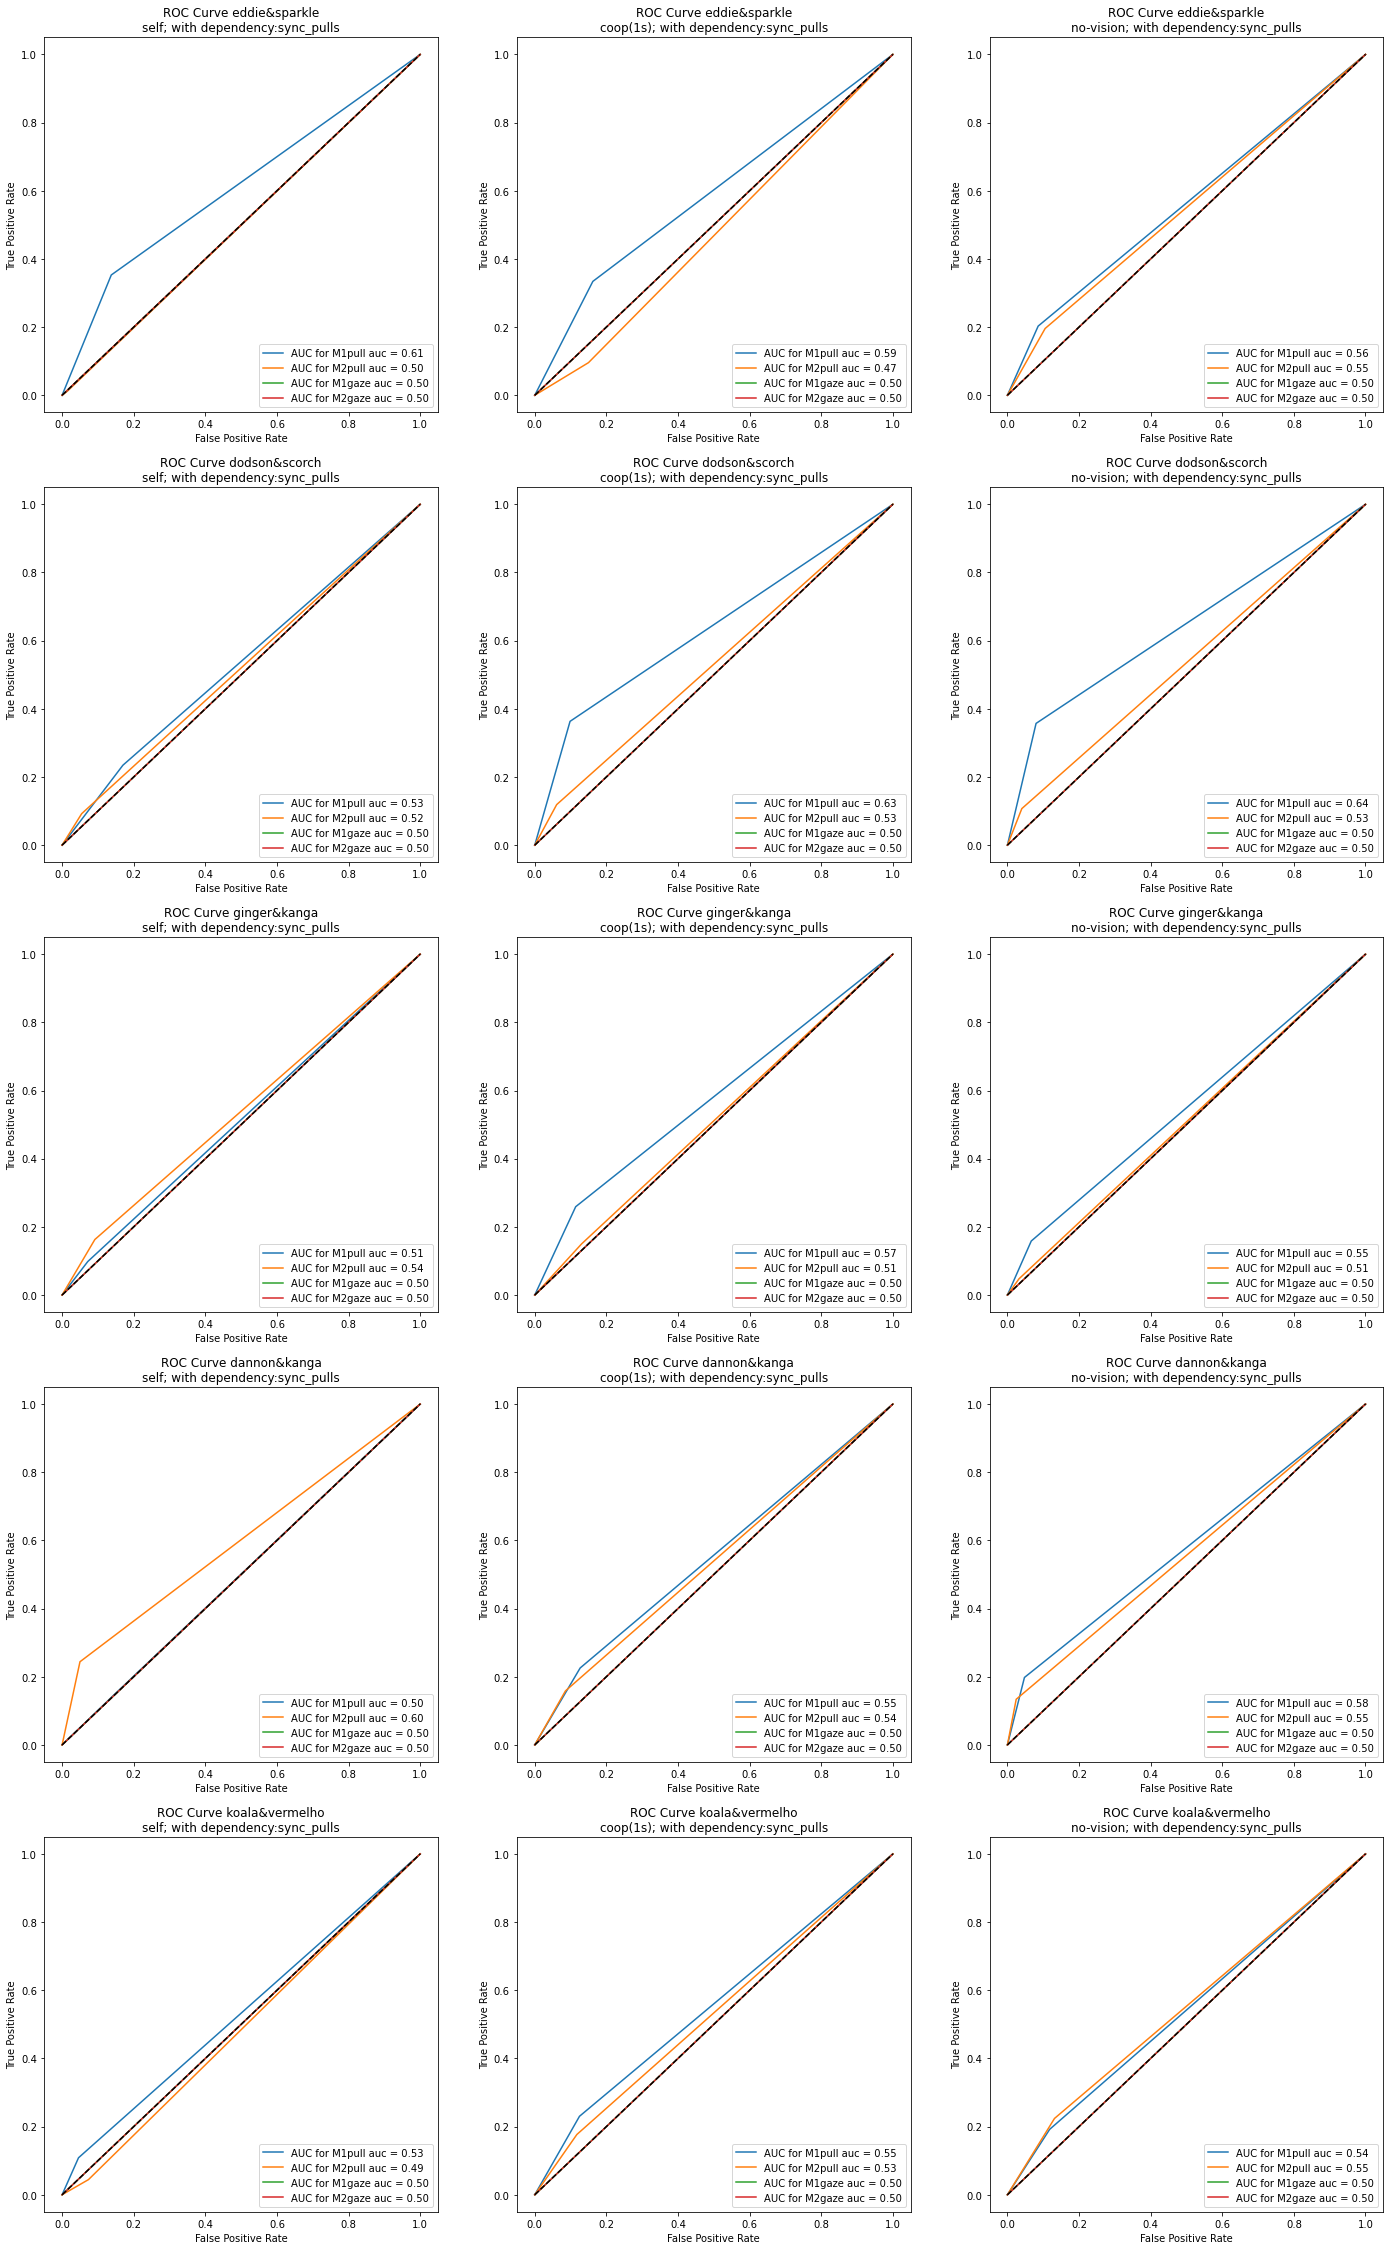

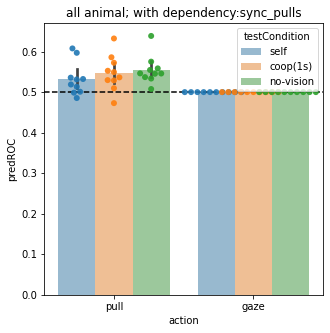

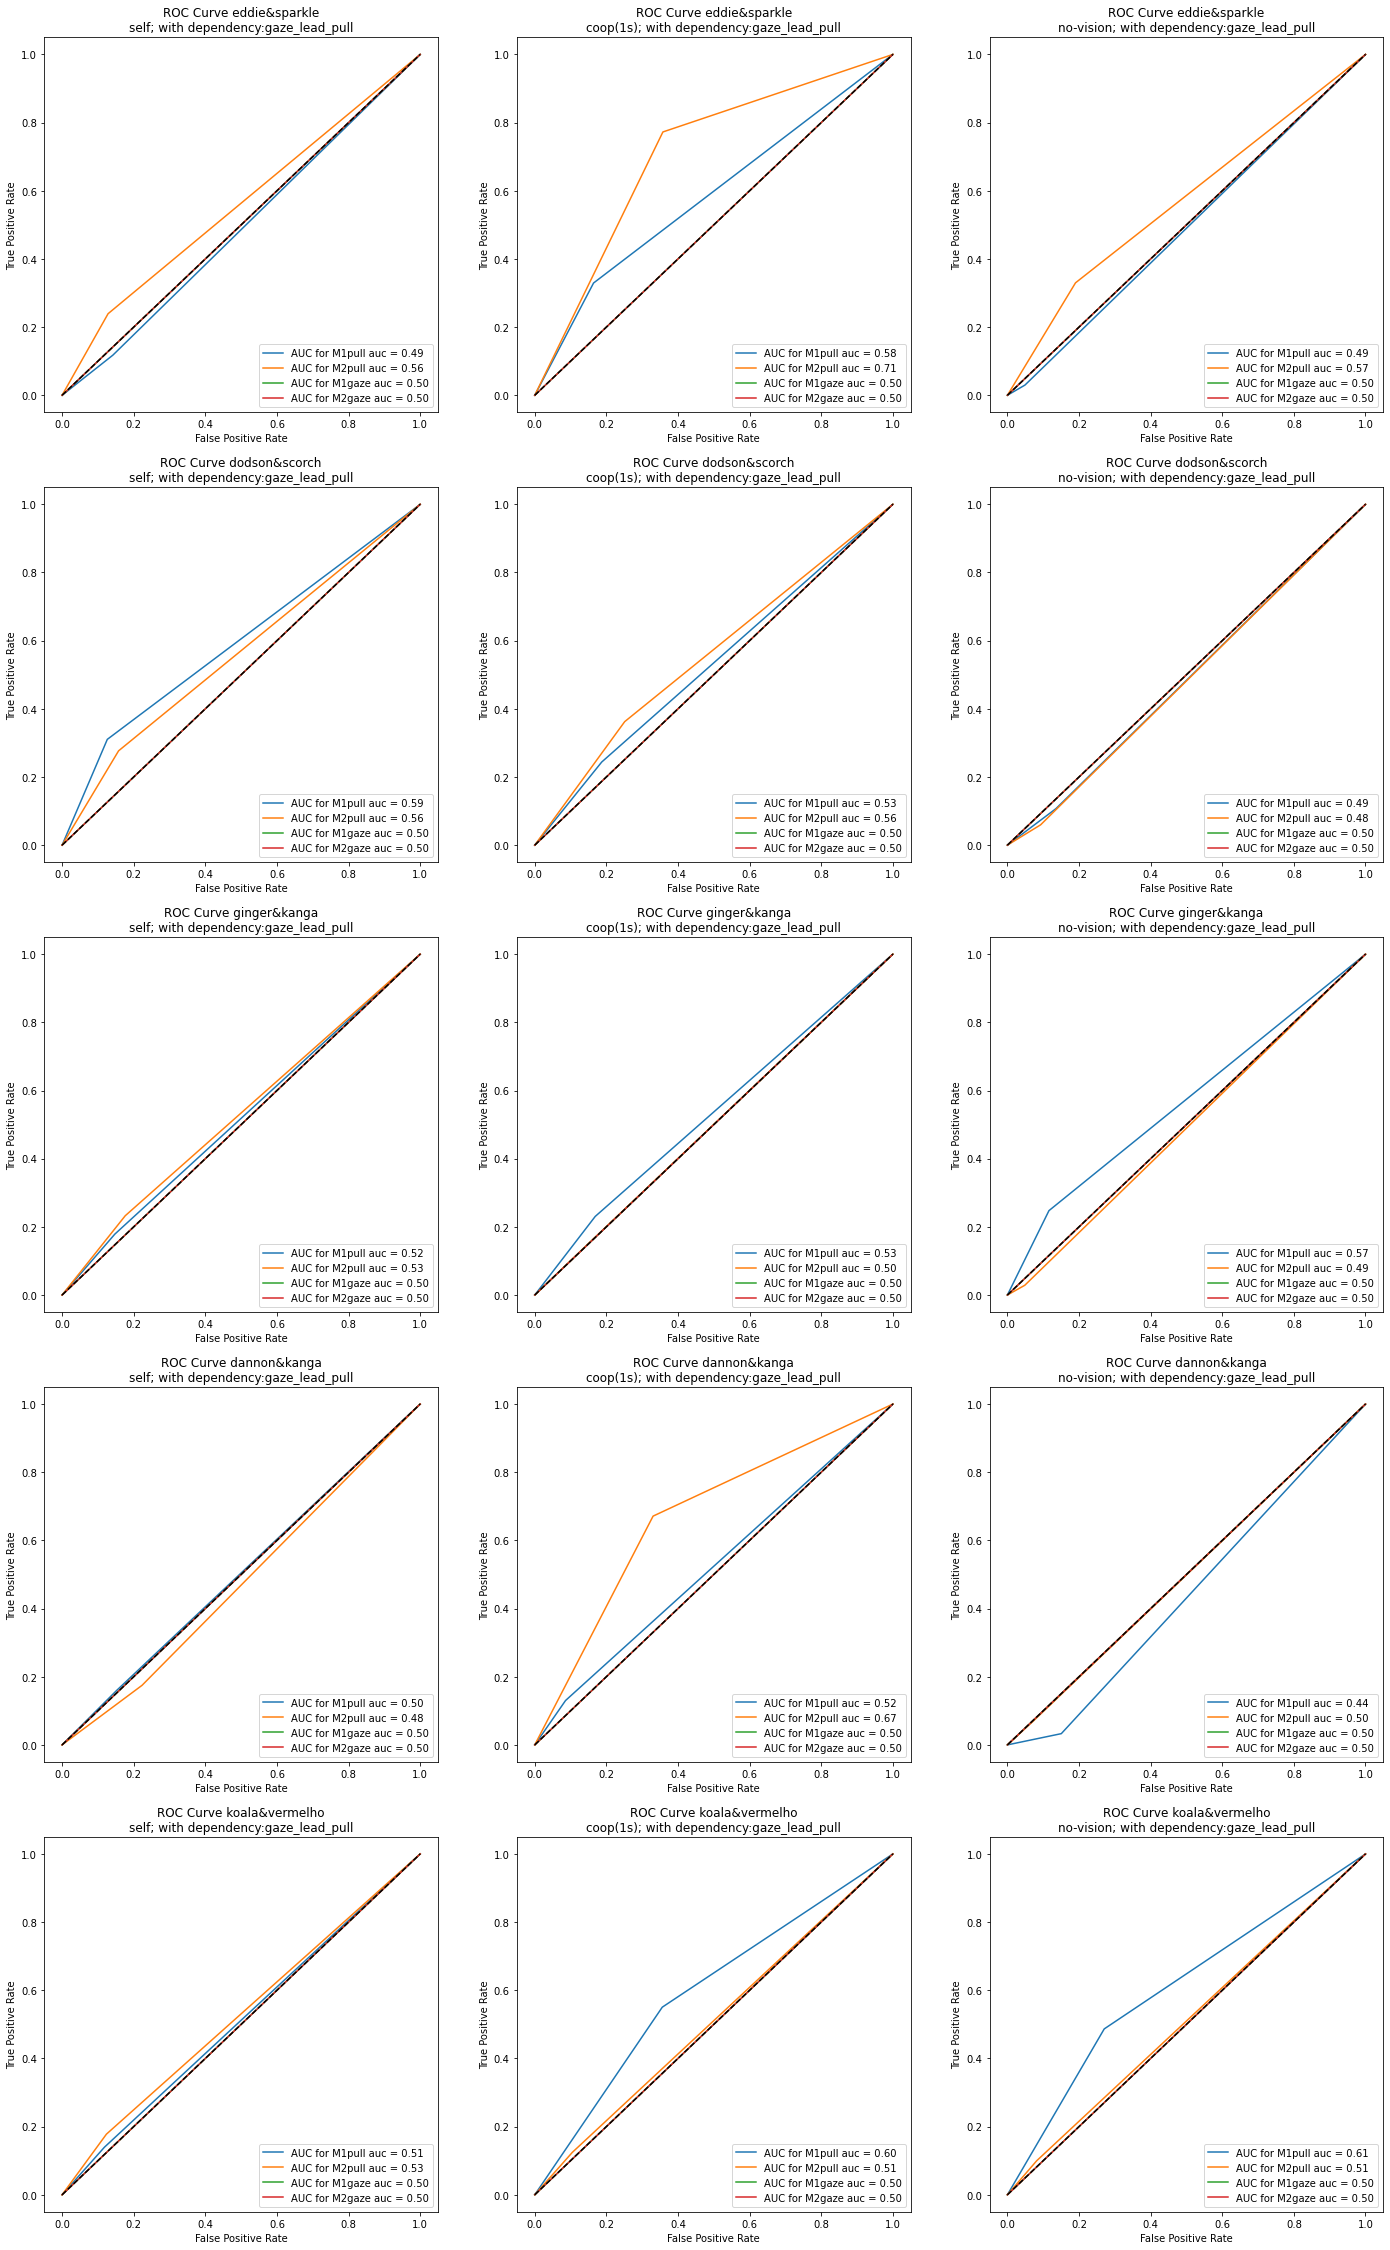

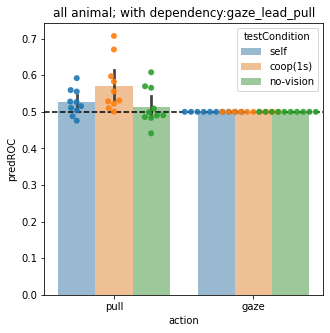

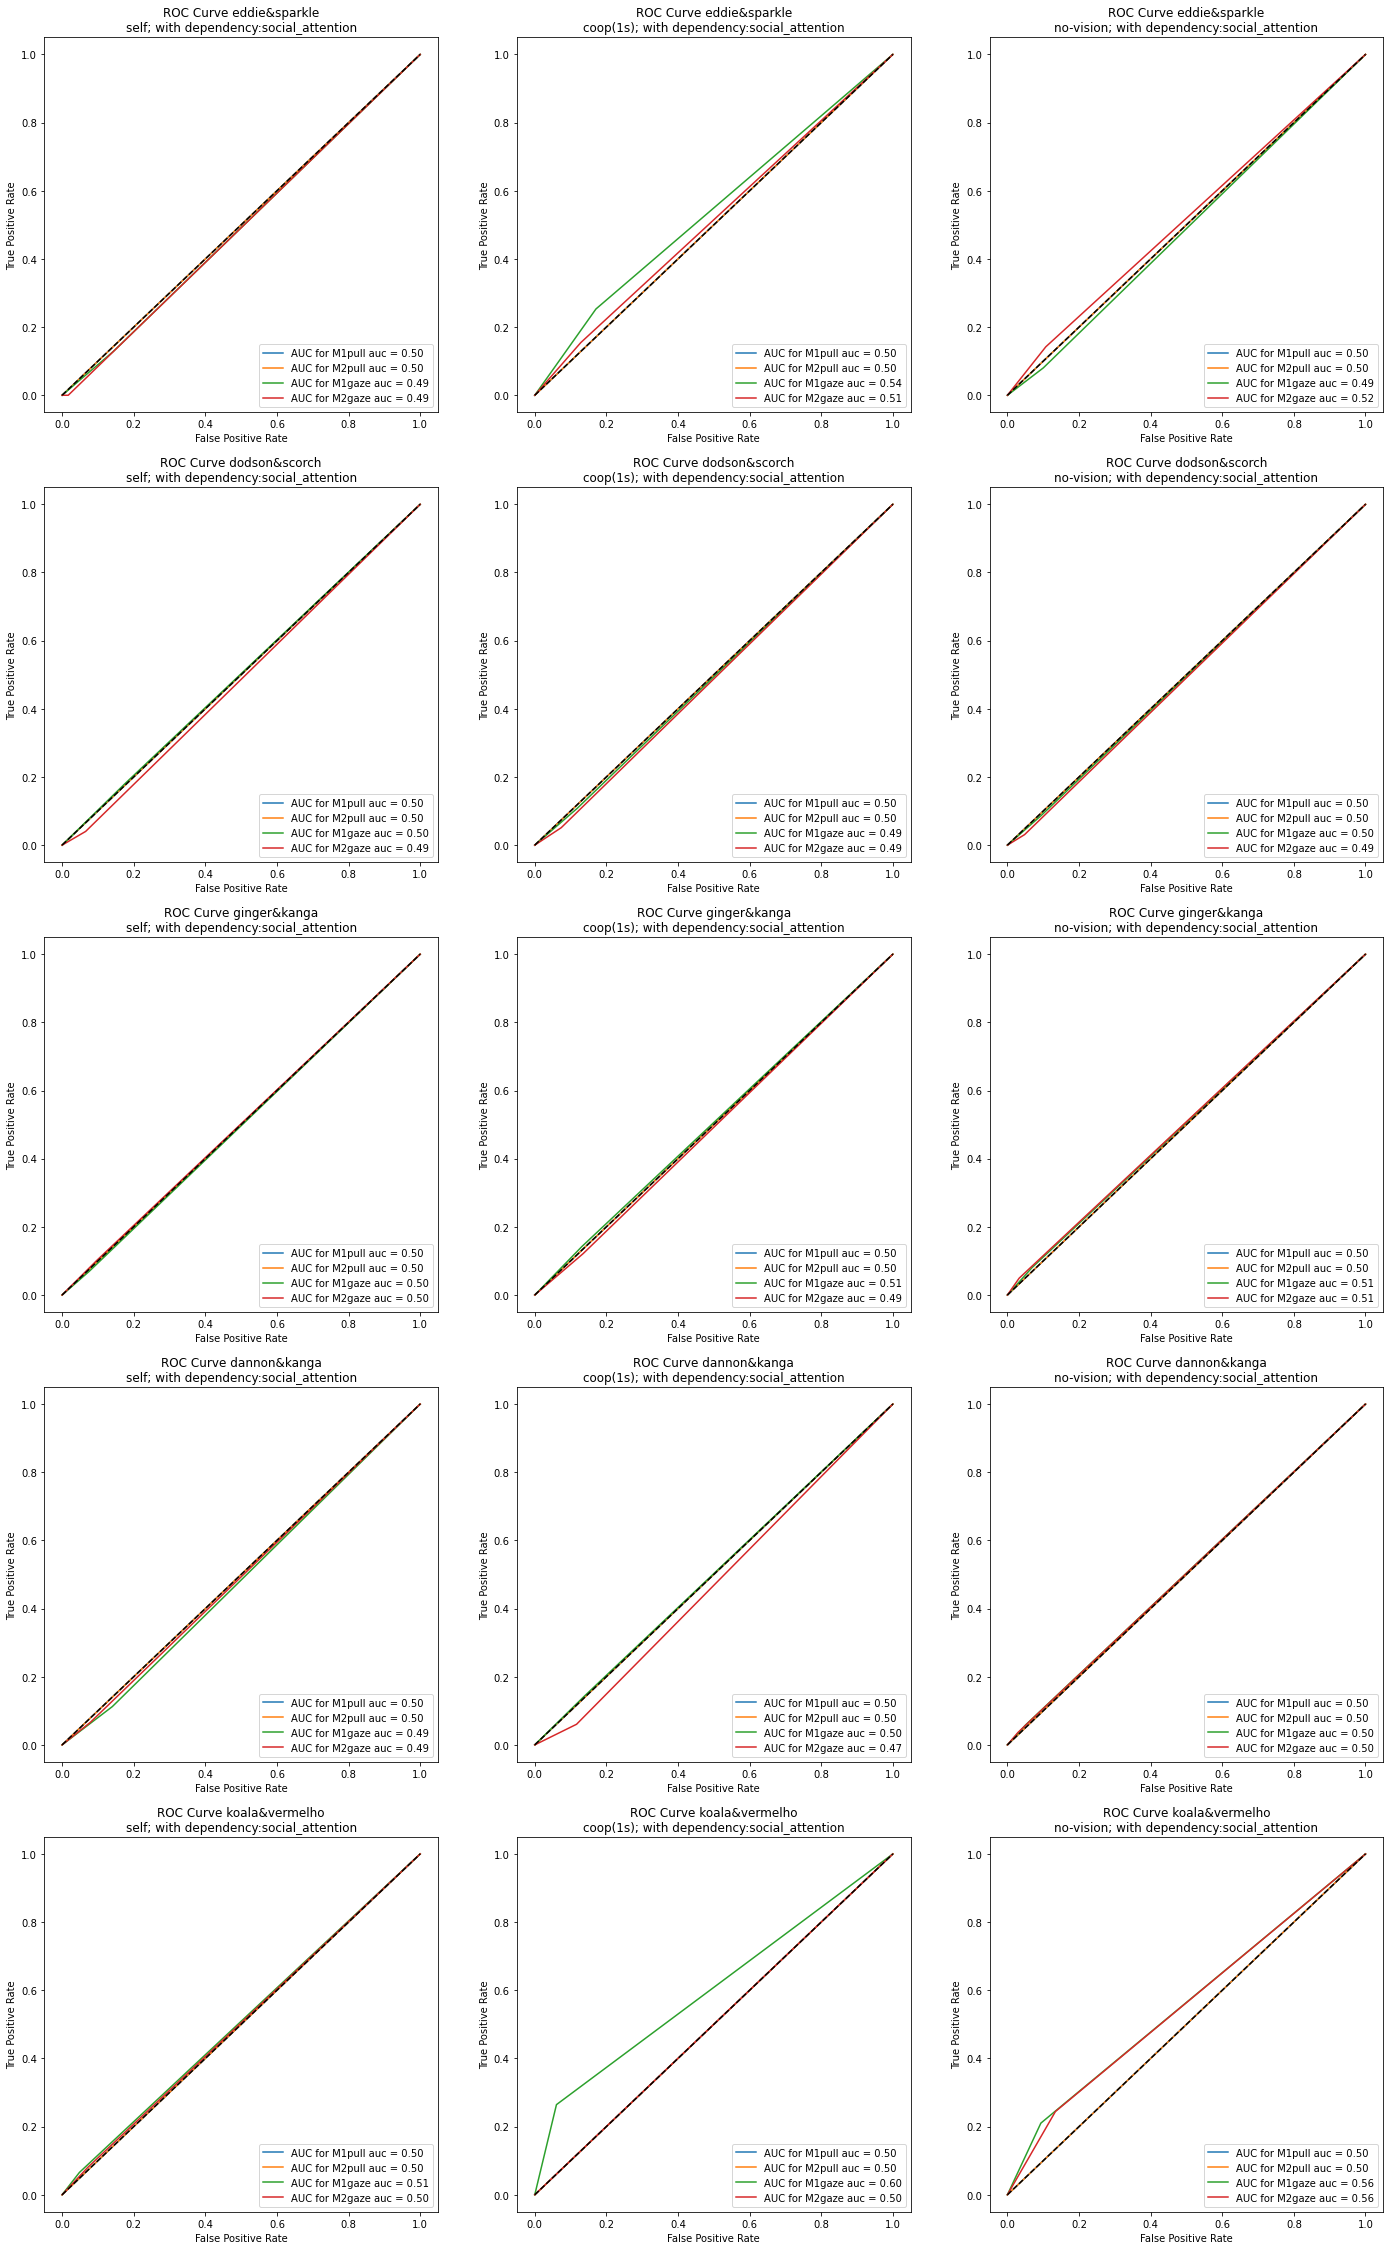

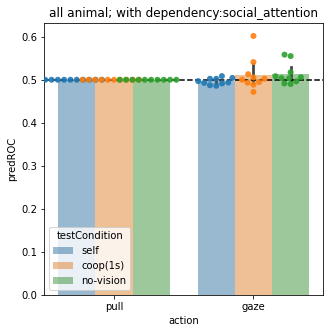

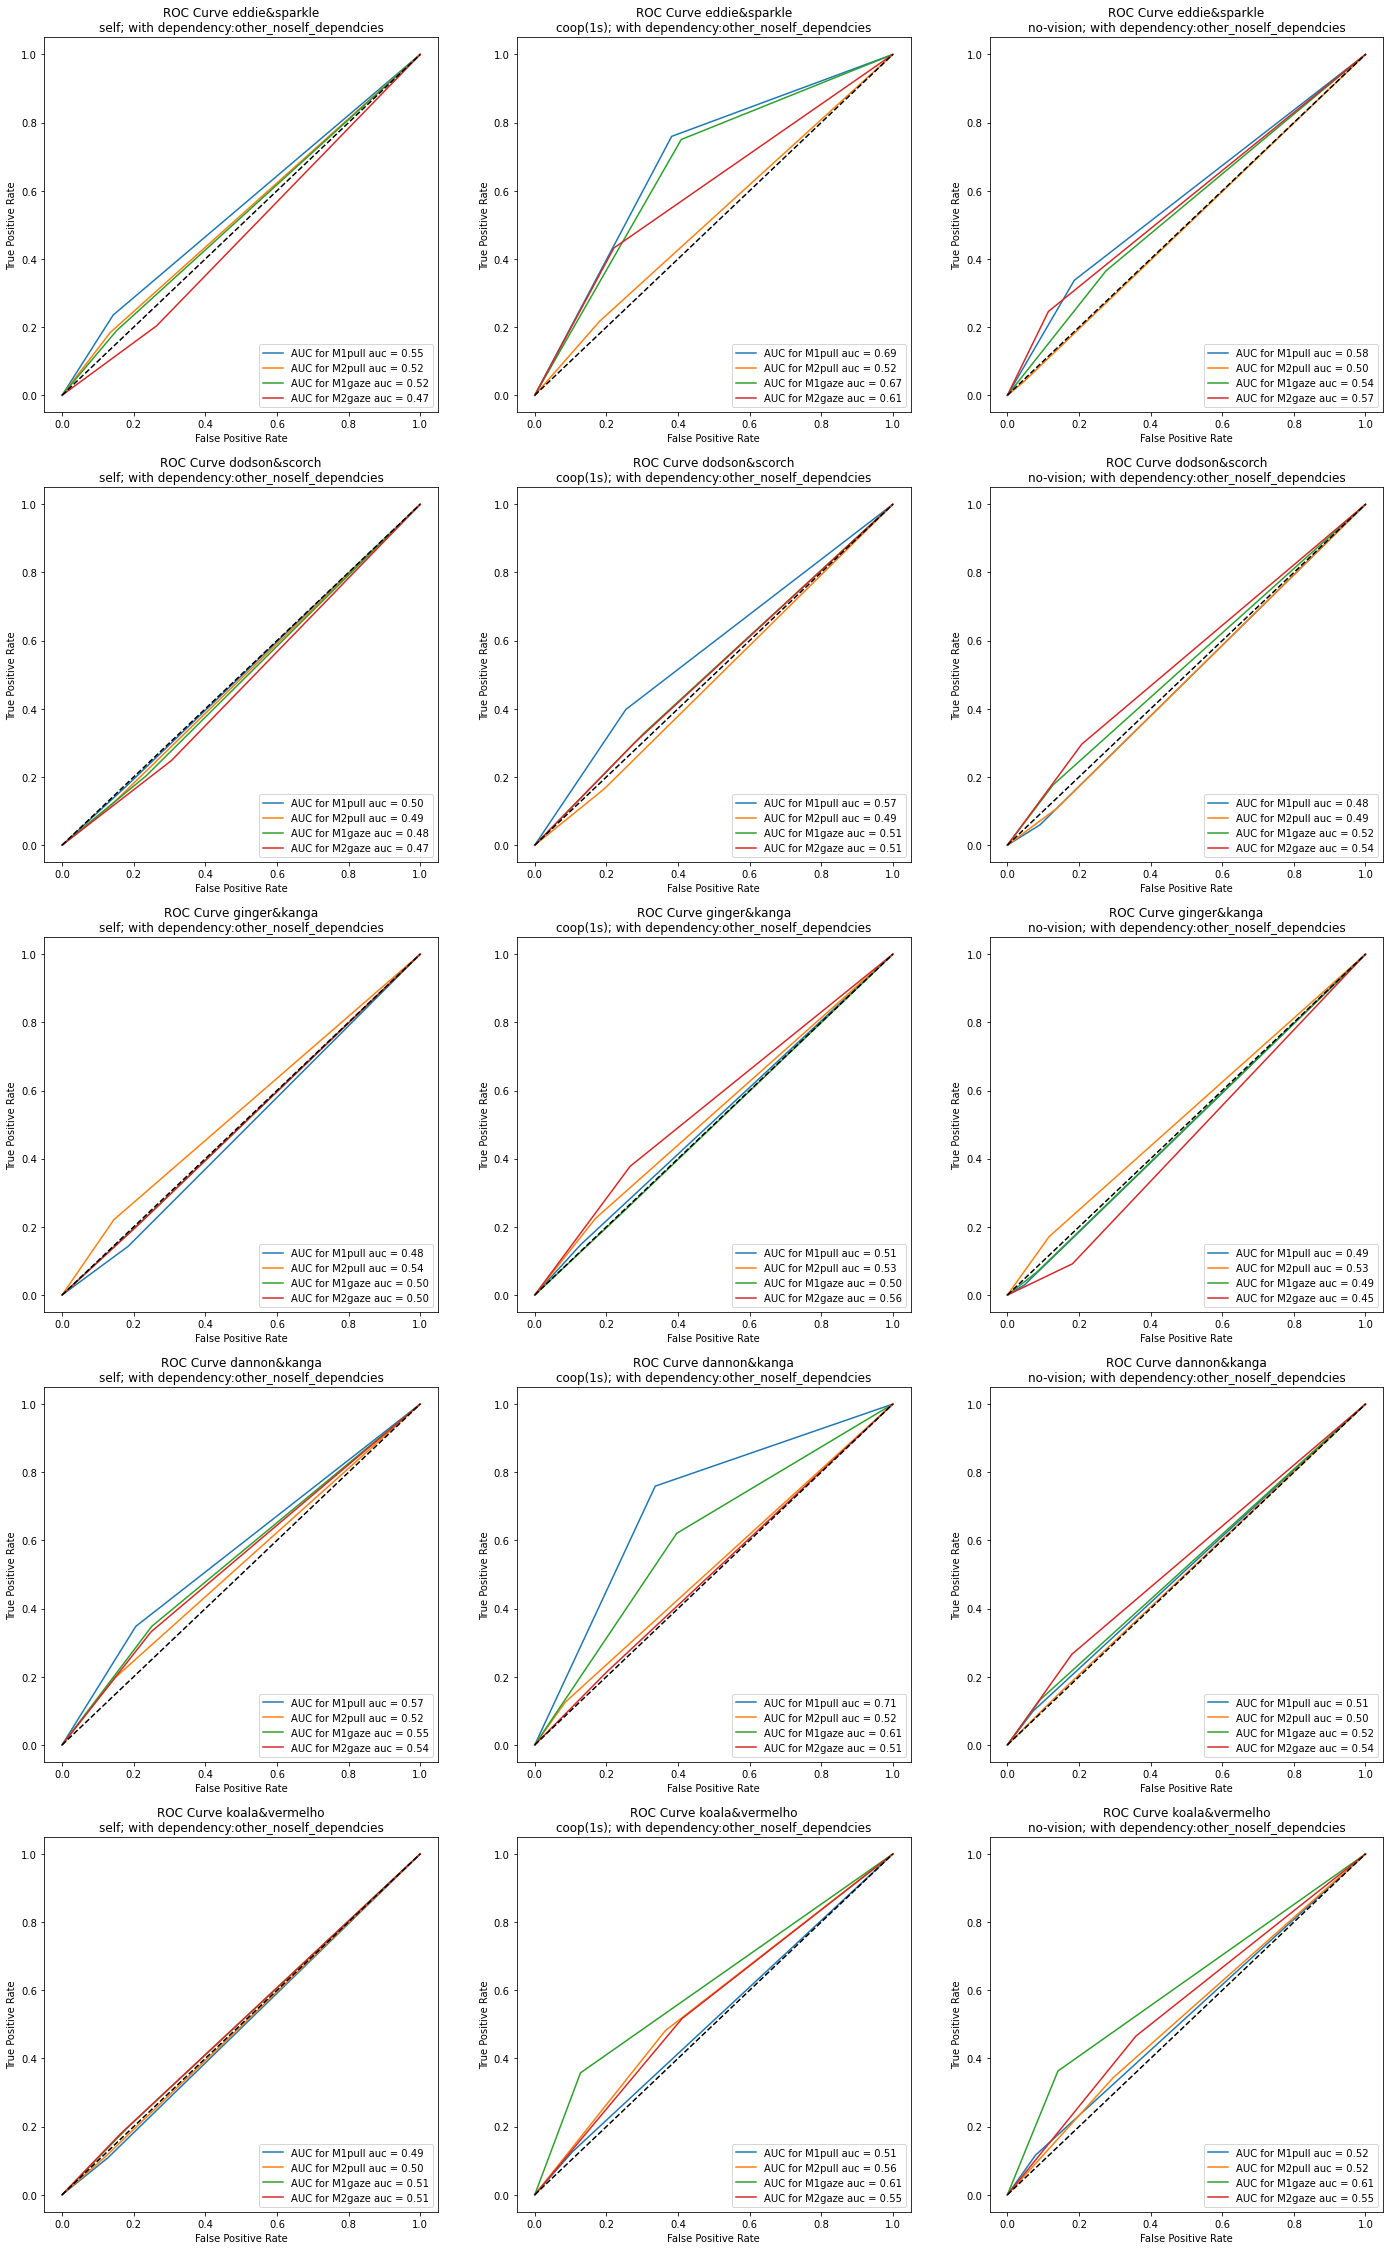

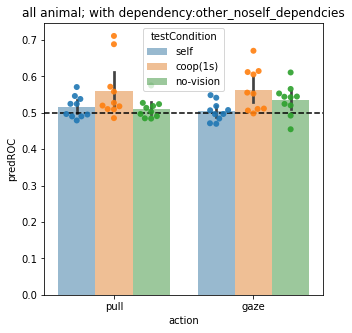

In [71]:
# PLOT multiple pairs in one plot, so need to load data seperately
moreSampSize = 0
mergetempRos = 0 # 1: merge different time bins

#
animal1_fixedorders = ['eddie','dodson','ginger','dannon','koala']
animal2_fixedorders = ['sparkle','scorch','kanga','kanga','vermelho']
# animal1_fixedorders = ['eddie',]
# animal2_fixedorders = ['sparkle',]
nanimalpairs = np.shape(animal1_fixedorders)[0]

temp_resolu = 1

# ONLY FOR PLOT!! 
# define DBN related summarizing variables
DBN_group_typenames = ['self','coop(1s)','no-vision']
DBN_group_typeIDs  =  [1,3,5]
DBN_group_coopthres = [0,1,0]
# DBN_group_typenames = ['coop(1s)']
# DBN_group_typeIDs  =  [3]
# DBN_group_coopthres = [1]
nDBN_groups = np.shape(DBN_group_typenames)[0]

# DBN model
toNodes = ['pull1_t3','pull2_t3','owgaze1_t3','owgaze2_t3']
# fromNodes = [ 'pull1_t0','pull2_t0','owgaze1_t0','owgaze2_t0',
#               'pull1_t1','pull2_t1','owgaze1_t1','owgaze2_t1',
#               'pull1_t2','pull2_t2','owgaze1_t2','owgaze2_t2']
fromNodes = ['pull1_t2','pull2_t2','owgaze1_t2','owgaze2_t2']
eventnames = ["M1pull","M2pull","M1gaze","M2gaze"]
nevents = np.shape(eventnames)[0]

timelagtype = '1secondlag'
# time_lags = ['t_-3','t_-2','t_-1']
# fromRowIDs =[0,1,2,3, 4,5,6,7, 8,9,10,11]
# time_lags = ['t_-2','t_-1']
# fromRowIDs =[4,5,6,7, 8,9,10,11]
time_lags = ['t_-1']
fromRowIDs =[8,9,10,11]

# hypothetical graph structure that reflect the strategies
# hypothetical graph structure that reflect the strategies
strategynames = ['all_threes','sync_pulls','gaze_lead_pull','social_attention',
                 'other_dependencies','other_noself_dependcies']
# strategynames = ['gaze_lead_pull'] # ['all_threes','sync_pulls','gaze_lead_pull','social_attention']
bina_graphs_specific_strategy = {
    'all_threes': np.array([[0,1,0,1],[1,0,1,0],[1,0,0,0],[0,1,0,0]]),
    'sync_pulls': np.array([[0,1,0,0],[1,0,0,0],[0,0,0,0],[0,0,0,0]]),
    'gaze_lead_pull':np.array([[0,0,0,0],[0,0,0,0],[1,0,0,0],[0,1,0,0]]),
    'social_attention':np.array([[0,0,0,1],[0,0,1,0],[0,0,0,0],[0,0,0,0]]),
    'other_dependencies': np.array([[1,0,1,0],[0,1,0,1],[0,1,1,1],[1,0,1,1]]),
    'other_noself_dependcies': np.array([[0,0,1,0],[0,0,0,1],[0,1,0,1],[1,0,1,0]]),
}
nstrategies_forplot = np.shape(strategynames)[0]

for istrg in np.arange(0,nstrategies_forplot,1):
    
    strategyname = strategynames[istrg]
    
    bina_graph_mean_strg = bina_graphs_specific_strategy[strategyname]

    
    # initialize a summary dataframe for plotting the summary figure across animals 
    ROC_summary_all = pd.DataFrame(columns=['animal','action','testCondition','predROC'])

    fig, axs = plt.subplots(nanimalpairs,nDBN_groups) # nDBN_groups(3) task conditions; 2 animal individual
    fig.set_figheight(8*nanimalpairs)
    fig.set_figwidth(8*nDBN_groups)

    for ianimalpair in np.arange(0,nanimalpairs,1):

        # initiate figure
        # fig, axs = plt.subplots(nDBN_groups,2) # nDBN_groups(3) task conditions; 2 animal individual
        # fig.set_figheight(8*nDBN_groups)
        # fig.set_figwidth(15*2)

        # load the DBN input data
        animal1_fixedorder = animal1_fixedorders[ianimalpair]
        animal2_fixedorder = animal2_fixedorders[ianimalpair]
        #
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'_3lags/'+cameraID+'/'+animal1_fixedorder+animal2_fixedorder+'/'
        if not mergetempRos:
            with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_'+str(temp_resolu)+'sReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes = pickle.load(f)
        else:
            with open(data_saved_subfolder+'//DBN_input_data_alltypes_'+animal1_fixedorder+animal2_fixedorder+'_mergeTempsReSo.pkl', 'rb') as f:
                DBN_input_data_alltypes = pickle.load(f)

        # load the DBN training outcome
        if moreSampSize:
            with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
                weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
            with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
                weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
            with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'_moreSampSize.pkl', 'rb') as f:
                sig_edges_diffTempRo_diffSampSize = pickle.load(f)
        else:
            with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
                weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
            with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
                weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
            with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder+animal2_fixedorder+'.pkl', 'rb') as f:
                sig_edges_diffTempRo_diffSampSize = pickle.load(f)

        # make sure these variables are the same as in the previous steps
        # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
        temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
        ntemp_reses = np.shape(temp_resolus)[0]
        #
        if moreSampSize:
            # different data (down/re)sampling numbers
            # samplingsizes = np.arange(1100,3000,100)
            samplingsizes = [1100]
            # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
            # samplingsizes = [100,500]
            # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
            samplingsizes_name = list(map(str, samplingsizes))
        else:
            samplingsizes_name = ['min_row_number']   
        nsamplings = np.shape(samplingsizes_name)[0]

        #
        temp_resolu = temp_resolus[0]
        j_sampsize_name = samplingsizes_name[0]    



        for igroup in np.arange(0,nDBN_groups,1):
            DBN_group_typename = DBN_group_typenames[igroup]

            DBN_input_data_tgt = DBN_input_data_alltypes[DBN_group_typename]
            weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][DBN_group_typename]
            weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][DBN_group_typename]
            # sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][DBN_group_typename]
            sig_edges_tgt = get_significant_edges(weighted_graphs_tgt,weighted_graphs_shuffled_tgt)

            # mean weight 
            weighted_graphs_mean_tgt = np.nanmean(weighted_graphs_tgt,axis=0)
            weighted_graphs_mean_tgt = weighted_graphs_mean_tgt * sig_edges_tgt

            bina_graphs_mean_tgt = sig_edges_tgt

            # Split data into training and testing sets
            train_data, test_data = train_test_split(DBN_input_data_tgt, test_size=0.2)
            test_data = DBN_input_data_tgt

            # get the true bhv data from the test_data set
            trueBhv = test_data[toNodes]

            # test on the test_data
            fromNodeBhv = test_data[fromNodes]

            # only use binary weight (not considering the weights)
            predBhv = 1*(np.dot(np.array(fromNodeBhv),bina_graph_mean_strg)>0)

            for ievent in np.arange(0,nevents,1):
                auc = roc_auc_score(np.array(trueBhv)[:,ievent], predBhv[:,ievent])

                fpr, tpr, _ = roc_curve(np.array(trueBhv)[:,ievent], predBhv[:,ievent])

                axs[ianimalpair,igroup].plot(fpr, tpr, 
                                             label=f'AUC for '+eventnames[ievent]+' auc = '+"{:.2f}".format(auc))
           
                # put data in the summarizing data frame
                if ievent<2: # for animal1
                    ROC_summary_all = ROC_summary_all.append({'animal':animal1_fixedorder,
                                                              'action':eventnames[ievent][2:],
                                                              'testCondition':DBN_group_typename,
                                                              'predROC':auc
                                                             }, ignore_index=True)
                else:
                    ROC_summary_all = ROC_summary_all.append({'animal':animal2_fixedorder,
                                                              'action':eventnames[ievent][2:],
                                                              'testCondition':DBN_group_typename,
                                                              'predROC':auc
                                                         }, ignore_index=True)
        
        
            axs[ianimalpair,igroup].plot([0, 1], [0, 1], 'k--')
            axs[ianimalpair,igroup].set_xlabel('False Positive Rate')
            axs[ianimalpair,igroup].set_ylabel('True Positive Rate')
            axs[ianimalpair,igroup].set_title('ROC Curve '+animal1_fixedorder+'&'+animal2_fixedorder
                                              +'\n'+DBN_group_typename+'; with dependency:'+strategyname)
            axs[ianimalpair,igroup].legend(loc='lower right')
        
        
    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        fig.savefig(figsavefolder+'withinCondition_DBNpredicition_fullDBN_binaryGraph_'+timelagtype+'_onlydependency'+strategyname+'.pdf')
   
    # plot the summarizing figure
    fig2, axs2 = plt.subplots(1,1)
    fig2.set_figheight(5)
    fig2.set_figwidth(5)
    seaborn.barplot(ax=axs2,data=ROC_summary_all,x='action',y='predROC',hue='testCondition',errorbar='ci',alpha=.5)
    seaborn.swarmplot(ax=axs2,data=ROC_summary_all,x='action',y='predROC',hue='testCondition',alpha=.9,size=6,dodge=True,legend=False)
    plt.plot([-0.5,1.5],[0.5,0.5],'k--')
    axs2.set_xlim([-0.5,1.5])
    axs2.set_title('all animal'+'; with dependency:'+strategyname)

    savefig = 1
    if savefig:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_singlecam_wholebodylabels_combinesessions_basicEvents_DBNpredictions/'+savefile_sufix+'/'+cameraID+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        fig2.savefig(figsavefolder+'withinCondition_DBNpredicition_fullDBN_binaryGraph_'+timelagtype+'_onlydependency'+strategyname+'_summarizingplot.pdf')






